# Sea ice comparisons: Observations vs Earth System Models
In this notebook, we will compare the ability of GFDL-MOM6-COBALT2 (current environmental forcing used by FishMIP models) and 11 CMIP6 models (see [Rohr et al 2023](https://doi.org/10.1038/s43247-023-00871-w)) to reproduce past sea ice conditions in the Southern Ocean (south of $30^{\circ}$S). The temporal range of these three data sources does not match, so we are comparing climatoligcal means for a period that is common to all: January 1982 to December 2010. Given the high seasonality of the Southern Ocean, we will compare climatologies for two seasons: summer (December to February) and winter (June to August).  
  
Observations come from [NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4](https://nsidc.org/data/g02202/versions/4). This dataset was regridded to match the GFDL-MOM6-COBALT2 (see the [Observations_sea-ice_data notebook](https://github.com/Fish-MIP/SOMEME/blob/main/scripts/Observations_sea-ice_data.ipynb) for details). This dataset uses a threshold of 10\% to define ice covered ocean, which means that any ocean areas with sea ice coverage lower than this threshold are classified as "ice free" areas. Earth System Models do not have such a threshold, so we will be applying it to ensure consistency across datasets.  

Some CMIP6 outputs used here are available in Gadi, however, we downloaded this data from ESGF (see the [CMIP6_sea-ice_data notebook](https://github.com/Fish-MIP/SOMEME/blob/main/scripts/CMIP6_sea-ice_data.ipynb) for details). The GFDL-MOM6-COBALT2 data used in this comparison is not in its native grid, instead it was regridded by the ISIMIP team, and it is available from the DKRZ server and the [ISIMIP data portal](https://data.isimip.org/).

## Loading relevant libraries

In [2]:
#Packages for file management
import os
from glob import glob

#Data wrangling
import pandas as pd
import numpy as np
import xarray as xr
from itertools import cycle
import string
import re

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec

## Setting working directory

In [3]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Sea ice concentration (SIC) data from observations
We will load the observational data that was previously regridded. Then we will apply the 10\% SIC threshold to allow for comparisons across datasets and finally calculate seasonal climatologies.

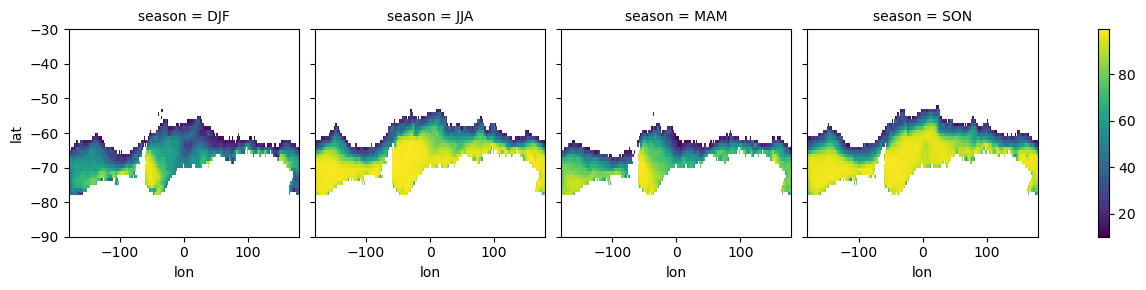

In [9]:
#Loading dataset
nsidc_ds = xr.open_dataarray('data/SIC_NASA/sic_nasa_goddard_60arcmin_1982-2010.nc')

#Change grid cells with values less than 0.1 to NAs and change to percentage
nsidc_clim = xr.where(nsidc_ds < 0.1, np.nan, nsidc_ds).groupby('time.season').mean()*100

#Checking result
nsidc_clim.plot(col = 'season')

## Loading sea ice data from GFDL-MOM6-COBALT2
Data from this model was regridded by ISIMIP and it was obtained from DKRZ. This is a global model, but we will only consider data for the Southern Ocean.

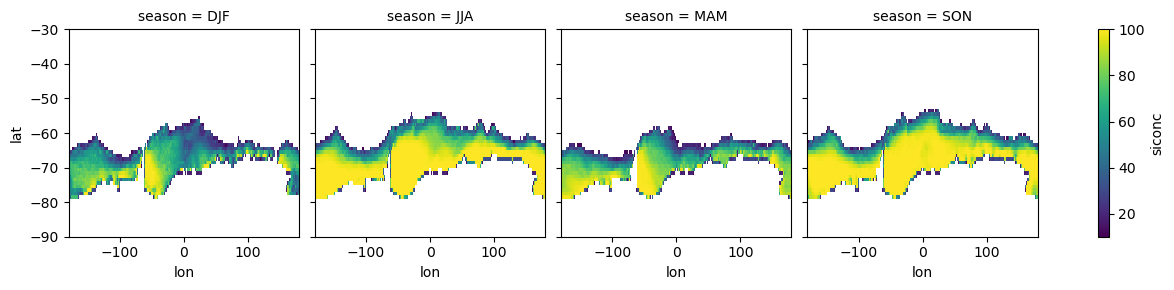

In [10]:
#Load GFDL data
gfdl_sic = xr.open_dataarray('data/gfdl-mom6-cobalt2_obsclim_siconc_60arcmin_global_monthly_1961_2010.nc')
#Select area and period of interest
gfdl_sic = gfdl_sic.sel(lat = slice(-30, -90), time = slice('1982', '2010'))
#Apply 10% SIC threshold to match observations
gfdl_sic = xr.where(gfdl_sic < 10, np.nan, gfdl_sic)
#Calculating seasonal climatologies
gfdl_clim = gfdl_sic.groupby('time.season').mean()
#Checking result
gfdl_clim.plot(col = 'season')

## Loading sea ice data from CMIP6 models
We will be including 11 models in our comparisons. We used [Rohr et al 2023](https://doi.org/10.1038/s43247-023-00871-w) as a reference point for our choice of CMIP6 models to be included in this comparison.

In [3]:
#Getting list of all models available in folder
cmip_files = glob('data/CMIP6/climatologies/*seasonal*')

#Initiliasing empty list to store results
cmip_ds = []

#Loop through each file
for f in cmip_files:
    #Get name of model to add as dimension
    model = re.findall('SImon_(.*)_hist', os.path.basename(f))
    #load data array
    da = xr.open_dataarray(f)
    #Keep summer and winter climatologies
    da_sub = da.loc[['DJF', 'JJA']]
    #If "type" dimension exists remove it
    if 'type' in da_sub.coords:
        da_sub = da_sub.drop_vars('type')
    #Adding model name and store in empty list
    cmip_ds.append(da_sub.expand_dims({'mod': model}))

#Create a single data array with all CMIP6 models
cmip_ds = xr.concat(cmip_ds, dim = 'mod')

#Save regional ensemble data
cmip_ds.to_netcdf('data/CMIP6/climatologies/clim_seasons_all_models.nc')

### Loading file with SIC data for all models

In [11]:
cmip_ds = xr.open_dataarray('data/CMIP6/climatologies/clim_seasons_all_models.nc')

## Calculating seasonal climatological mean and standard deviation

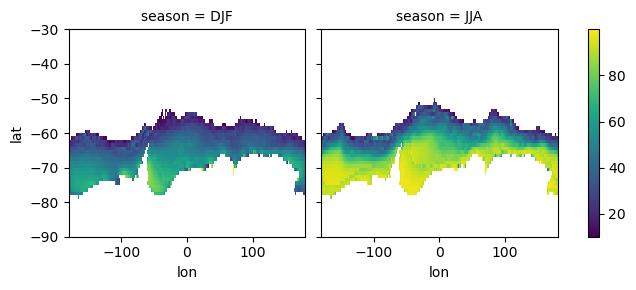

In [13]:
#Calculate ensemble mean and STD
cmip_mean = cmip_ds.groupby('season').mean('mod')
cmip_std = cmip_ds.groupby('season').std('mod')
#Checking results
cmip_mean.plot(col = 'season')

## Plotting winter and summer climatologies

/jobfs/114015396.gadi-pbs/ipykernel_741037/2132712143.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_comp_obs_ESMs.png', dpi = 300, bbox_inches = 'tight',
/jobfs/114015396.gadi-pbs/ipykernel_741037/2132712143.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_comp_obs_ESMs.png', dpi = 300, bbox_inches = 'tight',
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


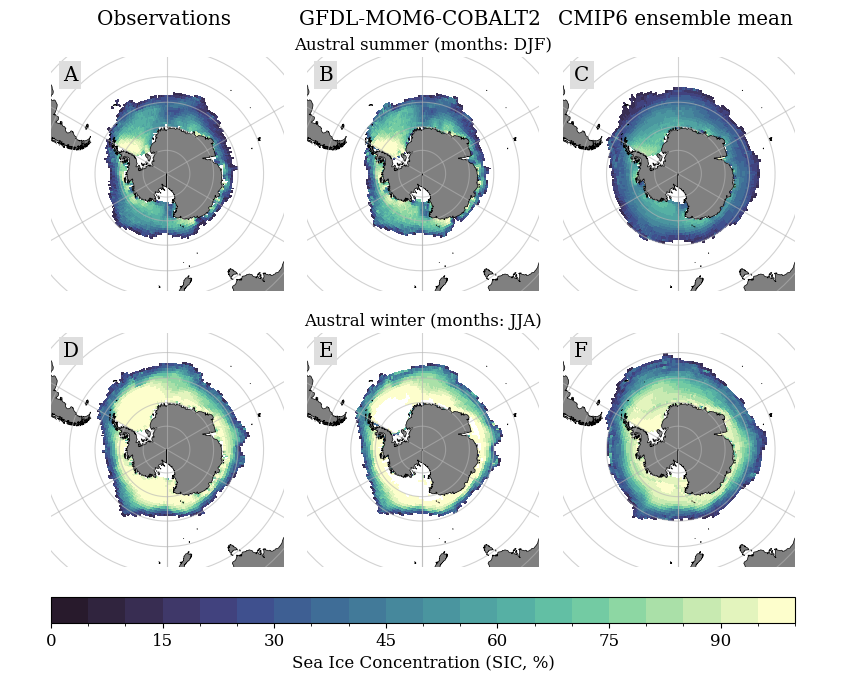

In [17]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 7.5], constrained_layout = True)

#Setting levels for colorbar
levels = np.arange(0, 101, 5)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Defining datasets to be plotted
data = ['Observations',
        'GFDL-MOM6-COBALT2', 
        'CMIP6 ensemble mean']

#Defining season names
seasonName = {'DJF': 'Austral summer (months: DJF)',  
              'JJA': 'Austral winter (months: JJA)'}

#Merge seasons and dasets to create a counter
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

#Create composite figure using a grid (3 rows for each season and a colourbar,
#and 3 columns for each dataset)
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data), 
                       height_ratios = (1, 1, 0.1), wspace = 0.1, hspace = 0.1)

#Initialise empty list for axes containing subplots
ax = {}

#Looping through counter to create plots
for i, coord in enumerate(counter):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Select dataset to be plotted
    if coord[0] == 'Observations':
        da = nsidc_clim.sel(season = coord[1])
    elif 'GFDL' in coord[0]:
        da = gfdl_clim.sel(season = coord[1])
    else:
        da = cmip_mean.sel(season = coord[1])
    
    p1 = da.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.deep_r, 
                            levels = levels, transform = ccrs.PlateCarree())
    #Set title for maps
    if i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title('', y = 1.01)

    #Add subtitle for seasons
    if i in [1, 4]:
        ax[i].text(0.5, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center',
                   verticalalignment = 'center', transform = ax[i].transAxes)
    
    #Add land
    ax[i].add_feature(land_50m)
    #Set extent of map
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, color = '#b4b4b4',
                         alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove outer frame
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Add colourbar
ax_col = fig.add_subplot(gs[-1, 0:])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', shrink = 0.5,
                  fraction = 0.2, label = 'Sea Ice Concentration (SIC, %)')

#Labelling plots - Getting the alphabet in upper case
labels = string.ascii_uppercase[0:6]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 6:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Save figure
plt.savefig('outputs/SIC_comp_obs_ESMs.png', dpi = 300, bbox_inches = 'tight',
           pad_inches = 0.05)

## Calculate differences between observations and modelled data
Our focus is on the summer and winter seasons, so we will calculate differences for these seasons only. We will substract the observations from the modelled data. This means that negative values show areas where models underestimate sea ice concentration, and positive values indicate the models overestimate sea ice.

In [31]:
cmip_obs = cmip_mean - (nsidc_clim.loc[['DJF', 'JJA']])
gfdl_obs = (gfdl_clim.loc[['DJF', 'JJA']])-(nsidc_clim.loc[['DJF', 'JJA']])

## Plotting differences

/jobfs/114015396.gadi-pbs/ipykernel_741037/2933752572.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_ESMs_minus_obs.png', dpi = 300, bbox_inches = 'tight',
/jobfs/114015396.gadi-pbs/ipykernel_741037/2933752572.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_ESMs_minus_obs.png', dpi = 300, bbox_inches = 'tight',
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


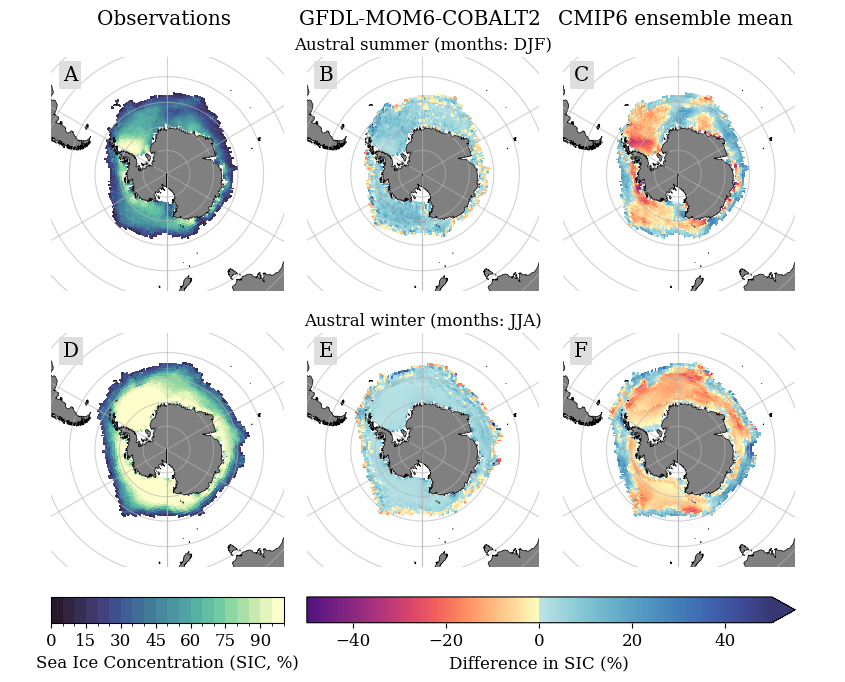

In [43]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 7.5], constrained_layout = True)

#Create colormap for differences
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
#Set NA values to show as white
mymap.set_bad('white')

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Defining datasets to be plotted
data = ['Observations',
        'GFDL-MOM6-COBALT2', 
        'CMIP6 ensemble mean']

#Defining season names
seasonName = {'DJF': 'Austral summer (months: DJF)',  
              'JJA': 'Austral winter (months: JJA)'}

#Merge seasons and dasets to create a counter
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

#Create composite figure using a grid (3 rows for each season and a colourbar,
#and 3 columns for each dataset)
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data), 
                       height_ratios = (1, 1, 0.1), wspace = 0.1, hspace = 0.1)

#Initialise empty list for axes containing subplots
ax = {}

#Looping through counter to create plots
for i, coord in enumerate(counter):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Select dataset to be plotted
    if coord[0] == 'Observations':
        da = nsidc_clim.sel(season = coord[1])
        p1 = da.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.deep_r, 
                            levels = np.arange(0, 101, 5), transform = ccrs.PlateCarree())
    else:
        if 'GFDL' in coord[0]:
            da_diff = gfdl_obs.sel(season = coord[1])
        else:
            da_diff = cmip_obs.sel(season = coord[1])
        p2 = da_diff.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = mymap, norm = divnorm,
                                transform = ccrs.PlateCarree())
    #Set title for maps
    if i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title('', y = 1.01)

    #Add subtitle for seasons
    if i in [1, 4]:
        ax[i].text(0.5, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center',
                   verticalalignment = 'center', transform = ax[i].transAxes)
    
    #Add land
    ax[i].add_feature(land_50m)
    #Set extent of map
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, color = '#b4b4b4',
                         alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove outer frame
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Add colourbar for SIC
ax_col = fig.add_subplot(gs[-1, 0])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', shrink = 0.5,
                  fraction = 0.2, label = 'Sea Ice Concentration (SIC, %)')
#Add colourbar for differences
ax_diff = fig.add_subplot(gs[-1, 1:])
cb2 = plt.colorbar(p2, cax = ax_diff, orientation = 'horizontal', shrink = 0.5,
                  extend = 'max', fraction = 0.2, label = 'Difference in SIC (%)')

#Labelling plots - Getting the alphabet in upper case
labels = string.ascii_uppercase[0:6]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 6:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Save figure
plt.savefig('outputs/SIC_ESMs_minus_obs.png', dpi = 300, bbox_inches = 'tight',
           pad_inches = 0.05)

## Plotting CMIP6 intermodel variability
We will show the ensemble mean and standard deviation calculated above. We will also calculate a coefficient of variation (CV) by dividing the standard deviation by the mean.

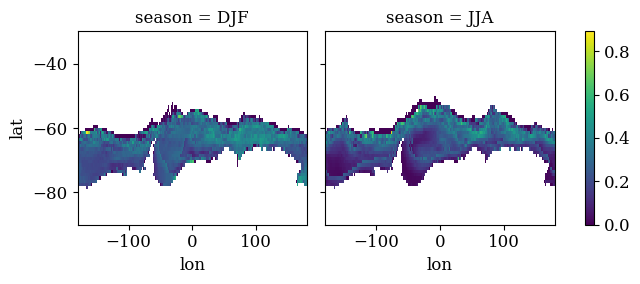

In [46]:
#Calculating CV
cmip_cv = cmip_std/cmip_mean
#Checking results
cmip_cv.plot(col = 'season')

/jobfs/114015396.gadi-pbs/ipykernel_741037/2136782035.py:101: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_summaries_CMIP6-ensemble.png', dpi = 300, bbox_inches = 'tight',
/jobfs/114015396.gadi-pbs/ipykernel_741037/2136782035.py:101: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig('outputs/SIC_summaries_CMIP6-ensemble.png', dpi = 300, bbox_inches = 'tight',
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


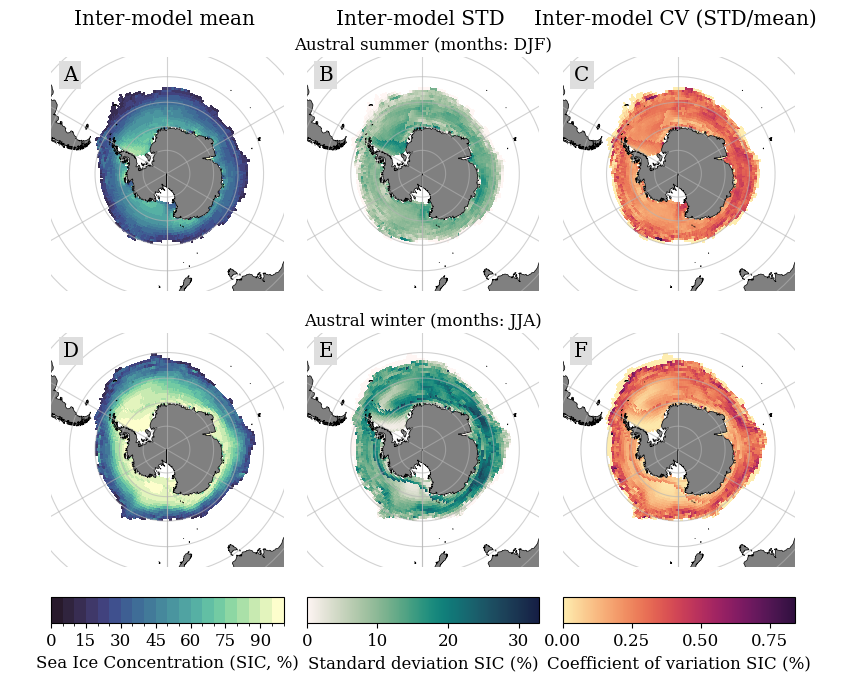

In [54]:
#Initialise figure - change width and height (6.4, 4.8)
fig = plt.figure(figsize = [9.6, 7.5], constrained_layout = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Define projection to polar
projection = ccrs.SouthPolarStereo()

#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                                   facecolor = 'gray', linewidth = 0.5)

#Defining datasets to be plotted
data = ['Inter-model mean',
        'Inter-model STD',
        'Inter-model CV (STD/mean)']

#Defining season names
seasonName = {'DJF': 'Austral summer (months: DJF)',  
              'JJA': 'Austral winter (months: JJA)'}

#Merge seasons and dasets to create a counter
counter = zip(cycle(data), np.repeat(list(seasonName), len(data)))

#Create composite figure using a grid (3 rows for each season and a colourbar,
#and 3 columns for each dataset)
gs = gridspec.GridSpec(nrows = len(seasonName)+1, ncols = len(data), 
                       height_ratios = (1, 1, 0.1), wspace = 0.1, hspace = 0.1)

#Initialise empty list for axes containing subplots
ax = {}

#Looping through counter to create plots
for i, coord in enumerate(counter):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    #Select dataset to be plotted
    if ' mean' in coord[0]:
        da = cmip_mean.sel(season = coord[1])
        p1 = da.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.deep_r, 
                                levels = np.arange(0, 101, 5), transform = ccrs.PlateCarree())
    elif ' STD' in coord[0]:
        da = cmip_std.sel(season = coord[1])
        p2 = da.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.tempo, 
                                transform = ccrs.PlateCarree())
    else:
        da = cmip_cv.sel(season = coord[1])
        p3 = da.plot.pcolormesh(ax = ax[i], add_colorbar = False, cmap = cm.cm.matter,
                                transform = ccrs.PlateCarree())
    #Set title for maps
    if i < 3:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title('', y = 1.01)

    #Add subtitle for seasons
    if i in [1, 4]:
        ax[i].text(0.5, 1.05, f'{seasonName[coord[1]]}', horizontalalignment = 'center',
                   verticalalignment = 'center', transform = ax[i].transAxes)
    
    #Add land
    ax[i].add_feature(land_50m)
    #Set extent of map
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())
    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, color = '#b4b4b4',
                         alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}
    #Remove outer frame
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Add colourbar for SIC
ax_col = fig.add_subplot(gs[-1, 0])
cb = plt.colorbar(p1, cax = ax_col, orientation = 'horizontal', shrink = 0.5,
                  fraction = 0.2, label = 'Sea Ice Concentration (SIC, %)')
#Add colourbar for STD
ax_std = fig.add_subplot(gs[-1, 1])
cb2 = plt.colorbar(p2, cax = ax_std, orientation = 'horizontal', shrink = 0.5,
                  fraction = 0.2, label = 'Standard deviation SIC (%)')
#Add colourbar for differences
ax_std = fig.add_subplot(gs[-1, 2])
cb3 = plt.colorbar(p3, cax = ax_std, orientation = 'horizontal', shrink = 0.5, 
                   fraction = 0.2, label = 'Coefficient of variation SIC (%)')

#Labelling plots - Getting the alphabet in upper case
labels = string.ascii_uppercase[0:6]
#Apply labels only to plots, not colorbars
for a in ax:
    if a < 6:
        ax[a].text(0.05, .9, labels[a], transform = ax[a].transAxes, 
                   fontsize = 'large',
                   bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

#Save figure
plt.savefig('outputs/SIC_summaries_CMIP6-ensemble.png', dpi = 300, bbox_inches = 'tight',
           pad_inches = 0.05)